In [25]:
%matplotlib inline

#Bibliotecas básicas do python
import numpy as np 
import seaborn as sns
import pandas as pd
from pandas import DataFrame
from pandas.util.testing import assert_frame_equal
from pandas_datareader import data
import matplotlib.pyplot as plt
import datetime
import math

#Bibliotecas para utilização do ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
import pmdarima as pm

#Bibliotecas para utilização das métricas do Sklearn
import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Bibliotecas para uso do statsmodels
import statsmodels.api as sm
from scipy import stats

#Biblioteca para ignorar os warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Período treinamento
treinamento_start_date = '2013-04-28'
treinamento_end_date = '2018-12-31'

#Período teste 
#OBS. As datas abaixo somente serão utilizadas futuramente nos modelos de previsão para testar os algoritmos
teste_start_date = '2019-01-01'
teste_end_date = '2019-12-31'

In [3]:
# Moedas que serão utilizadas 
tickers = ['GLD']

In [4]:
# O pandas_datareader será usado para carregar os dados de treinamento do Yahoo Finance
treinamento_dataset_GLD = data.DataReader(tickers[0], 'yahoo', treinamento_start_date, treinamento_end_date)

In [5]:
# pandas_datareader para carregar os dados de teste do Yahoo Finance da moeda OURO. 
# O dataset abaixo será utilizado nos modelos de previsão
teste_dataset_GLD = data.DataReader(tickers[0], 'yahoo', teste_start_date, teste_end_date)

In [6]:
#Estabelecendo a coluna 'Close' para oa Datasets
treinamento_dataset_GLD = treinamento_dataset_GLD.drop(['Adj Close','Open','Low','High','Volume'], axis=1)
teste_dataset_GLD = teste_dataset_GLD.drop(['Adj Close','Open','Low','High','Volume'], axis=1)
treinamento_dataset_GLD.head()

,Close
Date,
2013-04-29,142.300003
2013-04-30,142.770004
2013-05-01,141.110001
2013-05-02,141.919998
2013-05-03,142.089996


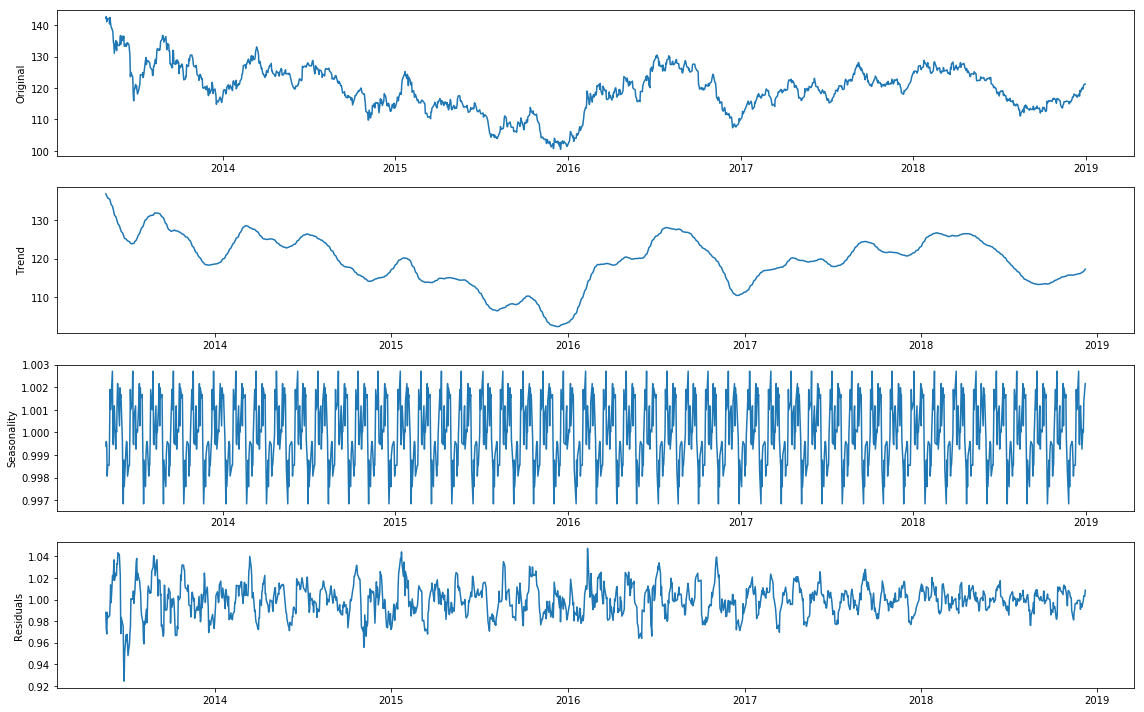

In [19]:
#Decomposição da série temporal
decomp = seasonal_decompose(time_series_train,model='multiplicative', period=30)
plt.figure(figsize=(16,10))
plt.subplot(411)
plt.plot(treinamento_dataset_GLD)
plt.ylabel('Original')
plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonality')
plt.subplot(414)
plt.plot(residual)
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

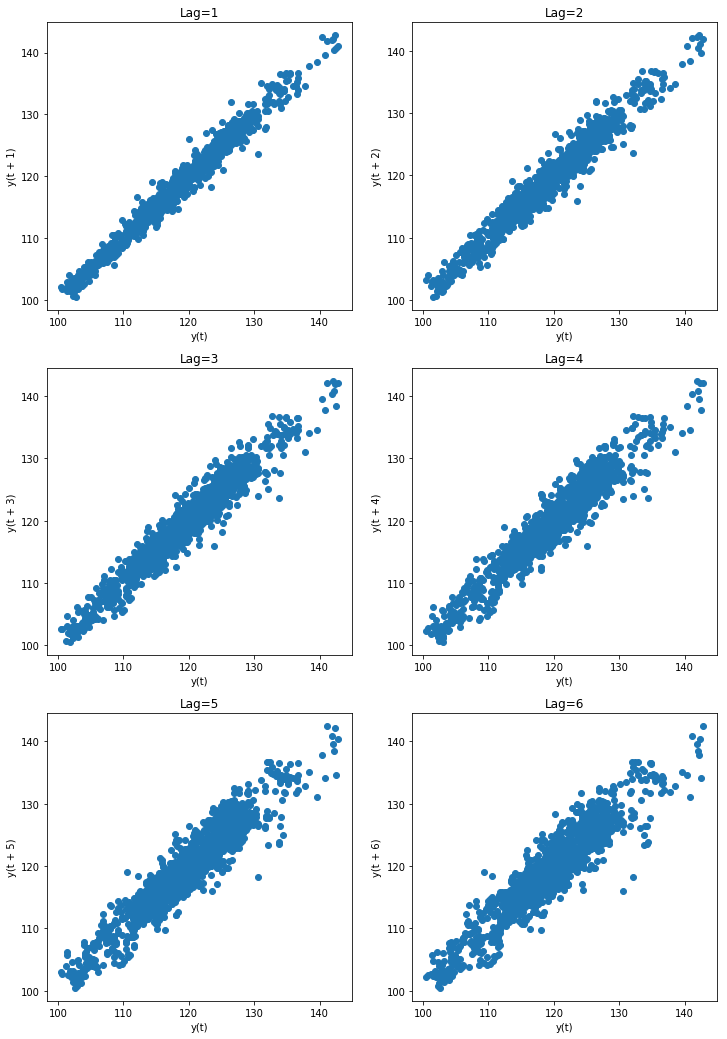

In [26]:
#Plotagem da Autocorrelação
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
plt.title('Autocorrelação da GLD')

# Coordenadas dos eixos para plotagem
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(treinamento_dataset_GLD["Close"], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.show()

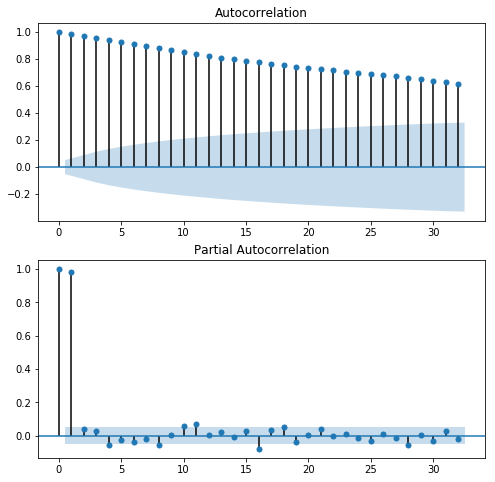

In [30]:
#Plotagem dos gráficos ACF e PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_acf(treinamento_dataset_GLD, ax = ax1)
plot_pacf(treinamento_dataset_GLD, ax = ax2)
plt.show()

In [31]:
#Definição do modelo
model = pm.auto_arima(treinamento_dataset_GLD['Close'], start_p=1, start_q=1,
                      #test='adf',       # usa o adftest para encontrar o melhor valor 'd'
                      max_p=3, max_q=3, # Máximo 'p' e 'q'
                      m=12,              # Frequência da série
                      d=1,           
                      stationary = False, #Estacionaridade
                      seasonal=True, #Sazonalidade
                      start_P=0, 
                      D=1, 
                      trace=True, #Se TRUE, a lista de modelos ARIMA considerados será reportada.
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True) #Se TRUE, fará a seleção gradual (mais rápido). Caso contrário, ele pesquisará todos os modelos.

#Treinamento do modelo
model.fit(treinamento_dataset_GLD['Close'])

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=4348.485, BIC=4374.767, Time=15.286 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=5264.143, BIC=5274.655, Time=0.139 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=4871.066, BIC=4892.091, Time=3.185 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=4346.568, BIC=4367.593, Time=18.342 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=5262.179, BIC=5267.436, Time=0.110 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=5261.164, BIC=5282.189, Time=1.215 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=4350.443, BIC=4381.981, Time=16.070 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit

ARIMA(order=(2, 1, 2), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)

In [32]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 1430
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -2160.144
Date:                              Mon, 13 Jul 2020   AIC                           4334.288
Time:                                      15:21:45   BIC                           4371.082
Sample:                                           0   HQIC                          4348.034
                                             - 1430                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.000      0.768      0.443      -0.001       0.001
ar.L1          1.33

In [46]:
#Faz a predição 
forecast_arima = model.predict(n_periods=len(teste_dataset_GLD['Close']))
forecast_arima = pd.DataFrame(forecast_arima, index = teste_dataset_GLD.index,columns=['Prediction'])
conf_int = model.predict(len(teste_dataset_GLD['Close']), return_conf_int=True, alpha = 0.05) #Pega o intervalo de confiança

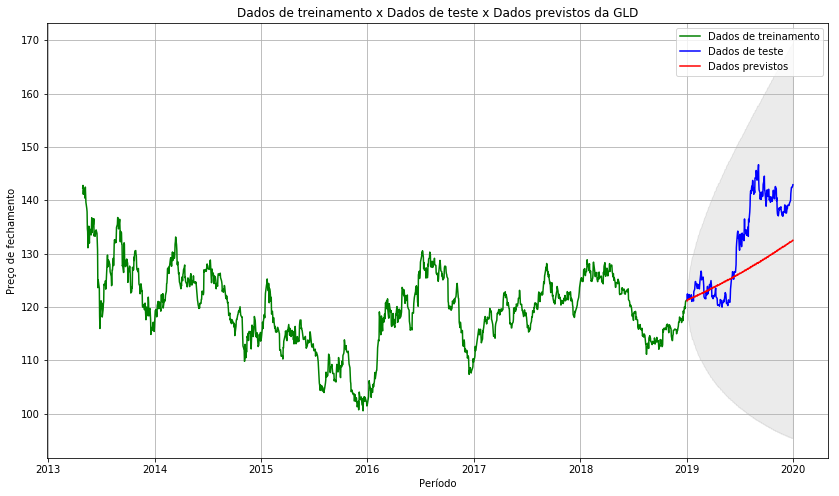

In [47]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos da GLD')
plt.plot(treinamento_dataset_GLD['Close'], color='green', label = 'Dados de treinamento')
plt.plot(teste_dataset_GLD['Close'], color = 'blue', label = 'Dados de teste')
plt.fill_between(teste_dataset_GLD.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
plt.show()

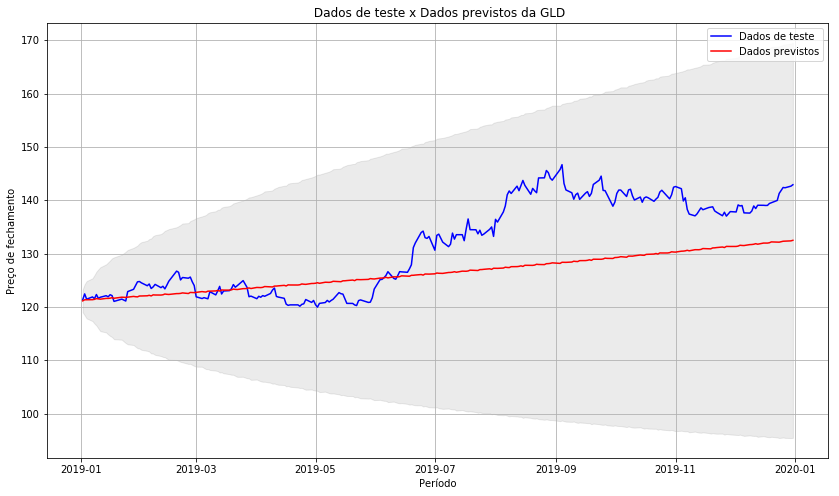

In [48]:
#Plotagem dos dados de teste e previsão
plt.figure(figsize=(14,8))
plt.title(' Dados de teste x Dados previstos da GLD')
plt.plot(teste_dataset_GLD['Close'], color = 'blue', label = 'Dados de teste')
plt.fill_between(teste_dataset_GLD.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
#Cálculo do erro
mse = mean_squared_error(teste_dataset_GLD['Close'], forecast_arima['Prediction'])
print('MSE: '+str(mse))
mae = mean_absolute_error(teste_dataset_GLD['Close'], forecast_arima['Prediction'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(teste_dataset_GLD['Close'], forecast_arima['Prediction']))
print('RMSE: '+str(rmse))

MSE: 61.82775146765312
MAE: 6.216490794258513
RMSE: 7.863062473849049
